In [1]:
"""
!pip install mss
!pip install matplotlib
!pip install tensorboardX python-dotenv
"""

'\n!pip install mss\n!pip install matplotlib\n!pip install tensorboardX python-dotenv\n'

## preparations

In [2]:
# debug
import time
import random
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [3]:
import os
from dotenv import load_dotenv

EXECUTABLE_NAME = os.getenv('EXECUTABLE_NAME')
GAME_WINDOW_NAME = os.getenv('GAME_WINDOW_NAME')

### camera

In [4]:
from src.gamenv import GameEnv

game_env = GameEnv("snes9x.exe", "mario - Snes9x 1.62.3", (20, 120, -10, -50))
camera = game_env.camera

(80, 80, 3)

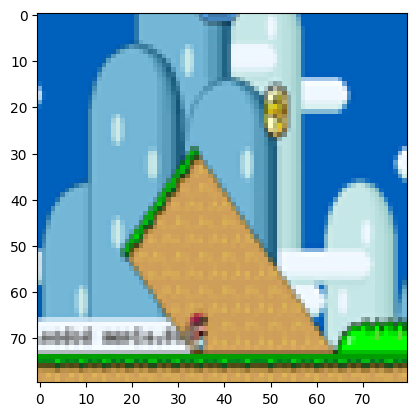

In [5]:
camera.set_foreground_game()
frame = camera.get_frame()
plt.imshow(frame)
frame.shape

### Agent

In [6]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
import gym

# Register the custom environment with Gym
from gym.envs.registration import register

register(
    id='CustomGameEnv-v0',
    entry_point='src.gamenv.gameenv:GameEnv',
    max_episode_steps=200,  # Adjust as needed
)

# Create the environment
env = gym.make('CustomGameEnv-v0')

obs = env.reset()
for _ in range(1000):  # Adjust as needed
    action = env.action_space.sample()  # Replace with your RL agent's action
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done or truncated:
        obs = env.reset()
env.close()

c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gym\envs\registration.py:498: UserWarning: WARN: Overriding environment CustomGameEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
c:\my tools\environments\pytorch_2_1_0_cuda_11_8\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for 

Exception: mario - Snes9x 1.62.3 cannot be minimized.

In [ ]:
D = 40_000
GAMMA = 0.99
LR = 0.00003

# NUM_EPISODES = 10000
SEQUENCE_LENGTH = 10
BATCH_SIZE = 10

EPS_NUM_STEPS = 2000
EPS_START = 0.05
EPS_END = 0.01
EPS_DECAY = (EPS_START - EPS_END) / (EPS_NUM_STEPS)

action_space = 3 # 4

load_model = False
model_name = "2023_12_26_23_13_56"

In [ ]:
import time
from itertools import count
from tensorboardX import SummaryWriter


timestr = time.strftime("%Y_%m_%d_%H_%M_%S")

In [ ]:
from src.memory import Memory, PrioritizedReplayMemory

# Initiliaze replay memory D to capacity N
replay_memory = PrioritizedReplayMemory(D, queue_push_thread=True)
sequence = Memory(SEQUENCE_LENGTH)

NameError: name 'D' is not defined

In [ ]:
from src.models.batch_model import DQN, phi, PromptQValues
from torch import nn

# Initialize action-value function Q with random weights

lstm_n = 512 #512
lstm_layers = 2

policy_net = DQN(action_space, lstm_n, lstm_layers).to(device) # used to store teta
target_net = DQN(action_space, lstm_n, lstm_layers).to(device) # used to store teta-1

if load_model:
    policy_net.load_state_dict(torch.load(f'./saved_models/{model_name}/policy_net'))
    
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.RMSprop(policy_net.parameters(), lr=LR)
loss_fn = nn.MSELoss()



In [ ]:
camera.set_foreground_game()
frame = camera.get_frame()
img = phi(observation=frame, device=device)
mean, std = img.mean([1,2]), img.std([1,2])
img = img.cpu().numpy()
img = img.transpose((1,2,0))
print(img.shape)
print(mean, std)

fig, axes = plt.subplots(1, 3, gridspec_kw={'wspace': 0, 'hspace': 0}, dpi=200)
axes[0].imshow(img[:,:,0])
axes[1].imshow(img[:,:,1])
axes[2].imshow(img[:,:,2])
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

ValueError: std evaluated to zero after conversion to torch.float32, leading to division by zero.

In [ ]:
def assert_sequence(sequence: Memory):
    if len(sequence) == SEQUENCE_LENGTH:
        sequence_state = sequence.render_simple()
        for i in range(len(sequence_state)):
            print(f"{i}")
            plt.imshow(sequence_state[i].cpu().numpy().transpose((1,2,0)))
            plt.show()
        input()

In [ ]:
global steps
steps = 0
episode = 0

In [ ]:
import datetime, threading
train_lock = threading.Lock()

loss = 0
policy_net.train()
writer = SummaryWriter(logdir="runs/"+timestr)

global thread_running
thread_running = False

def play():
    global thread_running
    global steps
    episode = 0
    epsilon = EPS_START
    time.sleep(2)
    camera.set_foreground_game()
    time.sleep(0.2)
    # with SummaryWriter(logdir="runs/"+timestr) as writer:
    try:
        while steps < D*50-50:
            time.sleep(0.1)
            with train_lock:
                ep_rewards = 0
                ep_qvalues = 0
                ep_loss = 0
                
                # Initialise sequence s1 = {x1} and preprocessed sequenced φ1 = φ(s1)
                observation = game_env.reset()
                state = phi(observation, device)
                last_reward = 0
                # sequence.clear()

                after_act_time = time.perf_counter()
                after_start_time_s = time.perf_counter()
                
                print(thread_running)
                if not thread_running:
                    return
                for t in count():
                    elapsed_after_act_time = time.perf_counter() - after_act_time
                    after_start_time_s = time.perf_counter()
                    step_time_start = time.perf_counter()
                    # print(len(sequence), t)

                    sequence_render_time = time.perf_counter()
                    sequence.push(state)
                    sequence_state = sequence.render_simple()
                    sequence_render_time = time.perf_counter() - sequence_render_time

                    # assert_sequence(sequence)

                    predict_time = time.perf_counter()

                    with torch.no_grad():
                        hn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)
                        cn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)
                        
                        q_value_action, (hn, cn) = policy_net(sequence_state, (hn, cn))
                        q_value_action = q_value_action[-1:]
                        # prompt_q_values.set_qvalues(q_value_action[0].cpu().numpy())
                        q_value_action = q_value_action.max(1)
                        
                        q_value = q_value_action[0].item()
                        ep_qvalues += q_value
                    
                    predict_time = time.perf_counter() - predict_time
                    if predict_time > 0.2:
                        print("big time")
                    
                    # With probability eps select a random action at
                    epsilon = epsilon - EPS_DECAY if epsilon > EPS_END else EPS_END
                    if random.uniform(0, 1) < epsilon:
                        action = torch.tensor([[random.randint(0, action_space-1)]], dtype=torch.long)
                    # otherwise select at = maxaQ*(phi(st), a; teta)
                    else:
                        action = q_value_action[1].view(1,1)
                        # print(action)

                    # Execute action at in emulator and observe reward rt and image xt+1
                    observation, reward, game_over = game_env.step(action.item())
                    after_start_time = time.perf_counter() - after_start_time_s
                    after_act_time = time.perf_counter()

                    ep_rewards += reward
                    #print(reward)
                    reward = torch.tensor([reward], dtype=torch.float32)

                    # Set st+1 = st, at, xt+1 and preprocess phit+1 = phi(st+1)
                    if game_over:
                        next_state = None # ordem provavelmente errada
                    else:
                        next_state = phi(observation, device)
                        # sequence.push(next_state)
                        # rendered, next_sequence_state = sequence.render()

                    #if sequence_state != None:
                    # replay_memory.push((sequence_state, action, reward, next_sequence_state))
                    
                    replay_memory.push_queue(state.cpu(), action, reward, next_state.cpu())
                    
                    # writer
                    writer.add_scalar("Reward/reward", reward, steps)
                    writer.add_scalar("Qvalue/qvalue", q_value, steps)
                    writer.add_scalar("Epsilon/epsilon", epsilon, steps)
                    if not game_over:
                        writer.add_scalar("Steps/Execution_Time", (time.perf_counter() - step_time_start), steps),
                        writer.add_scalar("Steps/elapsed_after_act_time", (elapsed_after_act_time), steps),
                        writer.add_scalar("Steps/after_start_time", (after_start_time), steps)
                        writer.add_scalar("Steps/sequence_render_time", sequence_render_time, steps)
                        writer.add_scalar("Steps/predict_time", predict_time, steps)
                        
                    writer.flush()
                    
                    # adding ep log
                    ep_rewards += reward

                    # sequence_state = next_sequence_state 
                    state = next_state
                    steps += 1
                    if game_over:
                        
                        # ep log
                        ep_reward_mean = ep_rewards / (t+1)
                        writer.add_scalar("Episode/reward_mean", ep_reward_mean, episode)

                        break
                episode += 1
                # writer.flush()
    except Exception as e:
        print(e)
        thread_running = False
    
def train():
    global thread_running
    train_steps = 0
    last_play_steps = 0
    K = 0

    while True:

        if not thread_running:
            return
        
        if len(replay_memory) > BATCH_SIZE: # and steps > 200:
            with train_lock:
                with replay_memory.memory_lock:
                    K = ((steps - last_play_steps)) * 2
                    last_play_steps = steps
                    loss = []
                    total_loss = 0
                    for k in range(K):
                        optimizer.zero_grad()
                        clear_output(wait=True)
                        print(f"{k} / {K}")
                        loss.append(policy_net.q_train(target_net, optimizer, loss_fn, replay_memory.sample_sequence(BATCH_SIZE), GAMMA, lstm_n, lstm_layers, replay_memory, device))

                        if (k+1) % 10 == 0:
                            loss = torch.cat(loss)
                            loss = loss.mean()
                            loss.backward()
                            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 5.0)
                            optimizer.step()
                            total_loss += loss.item()
                            loss = []
                            
                    if len(loss) > 0:
                        # loss = torch.cat([policy_net.q_train(target_net, optimizer, loss_fn, replay_memory.sample_sequence(BATCH_SIZE), GAMMA, lstm_n, lstm_layers, replay_memory, device) for _ in range(K)])
                        loss = torch.cat(loss)
                        loss = loss.mean()
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 5.0)
                        optimizer.step()
                        total_loss += loss.item()
                        clear_output()
                    print(f"total_loss:{total_loss}")
            # ep_loss += loss
            writer.add_scalar("Loss/loss", total_loss, train_steps)
            """
            if (t+1) % SEQUENCE_LENGTH == 0:
                clear_output(wait=True)
                print('loss:', ep_loss, 'step:', steps, 'epsilon:', epsilon, 'last_reward:', ep_rewards, 'ep:', episode)
                writer.add_scalar("Loss/ep_loss", ep_loss / SEQUENCE_LENGTH, steps)
                writer.add_scalar("Reward/ep_rewards", ep_rewards / SEQUENCE_LENGTH, steps)
                writer.add_scalar("Qvalue/ep_qvalues", ep_qvalues / SEQUENCE_LENGTH, steps)
                ep_rewards = 0
                ep_qvalues = 0
                ep_loss = 0
            """
            """
            if train_steps%100 == 0:
                clear_output(wait=True)
                print(f"loss: {loss}")
            """
            train_steps += 1
            if train_steps % 20 == 0:
                target_net.load_state_dict(policy_net.state_dict())
            time.sleep(0.1)
        else:
            print("dont have sufficient memory to train...")
            time.sleep(1)


In [ ]:
replay_memory.start_queue_thread()

In [ ]:
play_thread = threading.Thread(target=play, daemon=True)
train_thread = threading.Thread(target=train, daemon=True)

thread_running = True

play_thread.start()
train_thread.start()
print("threads started...")

play_thread.join()
train_thread.join()
# replay_memory.thread.join()
print("threads ended.")

total_loss:0.1244007358327508
threads ended.


In [ ]:
from src.models.batch_model import prompt_conv
sequence_state = replay_memory.sample_sequence(5)
print(len(sequence_state[0]))
# sequence_state = sequence.render_simple()
print(sequence_state[0])
prompt_conv(sequence_state)

5
(tensor([[[-0.2450, -0.2450, -0.2450,  ..., -0.2450, -0.2450, -0.2450],
         [-0.2450, -0.2450, -0.2450,  ..., -0.2450, -0.2450, -0.2450],
         [-0.2450, -0.2450, -0.2450,  ..., -0.2450, -0.2450, -0.2450],
         ...,
         [ 4.3938,  4.3981,  4.3981,  ...,  4.3377,  4.0833,  4.1615],
         [ 4.3836,  4.3981,  4.3981,  ...,  4.3395,  4.0931,  4.1708],
         [ 4.3869,  4.3981,  4.3981,  ...,  4.3859,  4.3348,  4.3555]],

        [[ 0.4148,  0.5830,  0.7602,  ..., -0.6283, -0.5645, -0.3477],
         [ 0.6441,  0.8757,  0.8940,  ..., -0.6342, -0.6297, -0.5006],
         [ 0.8747,  0.6404,  0.4311,  ..., -0.6342, -0.6338, -0.6164],
         ...,
         [ 0.8536,  0.8370,  0.8370,  ...,  0.9960,  1.6944,  1.4790],
         [ 0.8764,  0.8370,  0.8370,  ...,  0.9926,  1.6790,  1.4651],
         [ 0.8682,  0.8370,  0.8370,  ...,  0.8686,  1.0085,  0.9647]],

        [[ 1.3233,  1.5560,  1.8015,  ..., -0.2011, -0.0925,  0.2726],
         [ 1.6471,  1.9744,  1.9961,  ...,

AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:

import os

save_model_dir = './saved_models'

if not os.path.exists(f'{save_model_dir}'):
    os.mkdir(f'{save_model_dir}')
if not os.path.exists(f'{save_model_dir}/{timestr}'):
    os.mkdir(f'{save_model_dir}/{timestr}')

torch.save(policy_net.state_dict(), f'{save_model_dir}/{timestr}/policy_net')
torch.save(target_net.state_dict(), f'{save_model_dir}/{timestr}/target_net')

In [ ]:
def assert_memory():
    sequence = replay_memory.sample_sequence(3)

    states, actions, rewards, next_states = *zip(*sequence), # let the ',' to not give syntax error
    sequence_length = len(states) # - 1

    states = torch.stack(states)
    actions = torch.cat(actions)
    rewards = torch.cat(rewards)

    non_final_states_mask = torch.tensor(tuple(map(lambda s: s is not None, next_states)), device=device)
    non_final_next_states = torch.stack([s for s in next_states if s is not None])

    print(len(states))
    for i in range(len(states)):
        print(f"{i}")
        plt.imshow(states[i].cpu().numpy().transpose((1,2,0)))
        plt.show()
        plt.imshow(non_final_next_states[i].cpu().numpy().transpose((1,2,0)))
        plt.show()
assert_memory()

In [ ]:
exit()

In [ ]:
camera.set_foreground_game()

policy_net.eval()
while True:
    observation = game_env.reset()
    time.sleep(0.1)
    state = phi(observation, device)
    sequence.clear()
    
    for t in count():

        sequence.push(state)
        rendered = sequence.render_simple()

        hn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)
        cn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)
        with torch.no_grad():
            q_value_action, (hn, cn) = policy_net.forward_prompt(rendered, (hn, cn))
            q_value_action = q_value_action[-1:]
            print(q_value_action, end="")
            q_value_action = q_value_action.max(1)
            action = q_value_action[1].view(1,1)
            print(f", actions {action}")

        observation, reward, game_over = game_env.step(action.item())
        if game_over:
            next_state = None # ordem provavelmente errada
        else:
            next_state = phi(observation, device)
        state = next_state
        if game_over:
            break

In [ ]:
"""camera.set_foreground_game()
state = phi(camera.get_frame(), device)

policy_net.eval()
hn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)
cn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)

with torch.no_grad():
    q_value_action, (hn, cn) = policy_net(state.unsqueeze(0), (hn, cn))
    q_value_action = q_value_action[-1:]
    print(q_value_action)"""